# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) although we have taken steps to pull this data into a public s3 bucket: s3://myyelpbucket/yelp_business.json

# Installation and Initial Setup
We begin by installing the necessary libraries required to conduct analysis.

In [1]:
%%info

In [2]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.1")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
7,application_1588606342985_0008,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl (10.0 MB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)

  Using cached matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached kiwisolver-1.2.0-cp36-cp36m-manylinux1_x86_64.whl (88 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

  Using cached seaborn-0.10.1-py3-none-any.whl (215 kB)
  Using cached scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl (26.1 MB)

# Importing
Now we import the installed packages from the previous block below.

In [3]:
import pandas as pd
from pandas import DataFrame
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
from pyspark.sql.types import *
from pyspark.sql.functions import split, explode, countDistinct, lower, col, format_number
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import year, format_number, date_format

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Loading Data
Using spark, we load the data from S3 into a dataframe object that we can manipulate further down in our analysis.

In [4]:
business_df = spark.read.json('s3://myyelpbucket/yelp_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Overview of Data
Displaying the number of columns and rows in our dataset.

In [5]:
f'Columns: {len(business_df.dtypes)}' + " | " + f'Rows: {business_df.count():}'

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'Columns: 14 | Rows: 209393'

Displaying the DataFrame schema below.

In [6]:
business_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

- business_id
- name
- city
- state
- categories

In [7]:
business_df.select('business_id', 'name', 'city', 'state', 'stars', 'categories').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+-----+--------------------+
|         business_id|                name|           city|state|stars|          categories|
+--------------------+--------------------+---------------+-----+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|  3.5|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|  5.0|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|  5.0|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|  2.5|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|  4.5|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+-----+--------------------+
only showing top 5 rows

# Analyzing Categories
Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

- How many businesses are categorized as Active Life, for instance
- What are the top 20 most popular categories available?


## Association Table
We need to "break out" these categories from the business ids. One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.


For instance, given **A):**

| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive **B):**

| business_id | categories |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |

What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

In [8]:
# A) 
business_df.select('business_id', 'categories').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|         business_id|          categories|
+--------------------+--------------------+
|f9NumwFMBDn751xgF...|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|Health & Medical,...|
|XNoUzKckATkOD1hP6...|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|Home Services, Pl...|
+--------------------+--------------------+
only showing top 5 rows

In [9]:
# B) 
business_df.select('business_id', explode(split(business_df.categories, ", ")).alias("categories")).where('categories != ""').withColumnRenamed("categories", "category").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|        category|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows

# Total Unique Categories
Finally, we are ready to answer the question: **what is the total number of unique categories available?**

In [10]:
business_df.select(explode(split(business_df.categories, ", ")).alias("categories")).where('categories != ""').withColumnRenamed("categories", "category").distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

# Top Categories By Business
Now let's find the top categories in this dataset by rolling up categories.

## Counts of Businesses / Category
So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be similar to the following:

| category | count |
|----------|-------|
| a        | 2     |
| b        | 4     |
| c        | 6     |


**Following code illustrates the 20 most popular categories in descending order:**

In [11]:
df = business_df.select(explode(split(business_df.categories, ", ")).alias("categories")).where('categories != ""').withColumnRenamed("categories", "category").groupBy('category').count().orderBy("count", ascending=False)
df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|63944|
|            Shopping|34644|
|                Food|32991|
|       Home Services|22487|
|       Beauty & Spas|20520|
|    Health & Medical|19227|
|      Local Services|15783|
|          Automotive|14720|
|           Nightlife|14211|
|                Bars|12400|
|Event Planning & ...|11263|
|         Active Life|10225|
|        Coffee & Tea| 8415|
|             Fashion| 8374|
|           Fast Food| 8106|
|          Sandwiches| 8064|
|American (Traditi...| 7596|
|       Home & Garden| 7331|
|         Hair Salons| 7303|
|               Pizza| 7302|
+--------------------+-----+
only showing top 20 rows

## Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories.

**Step 1: Organize desired chart values**

In [12]:
df = business_df.toPandas()
df = df['categories'].str.split(', ',expand=True)
top_20_categories = df.stack(dropna=True).reset_index(drop=True).to_frame('category')
top_20_categories = top_20_categories.groupby(['category']).size().reset_index(name='count').sort_values(['count'], ascending=[False])[:20].sort_values(by='count')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Step 2: Use matplotlib to create desired plot**

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

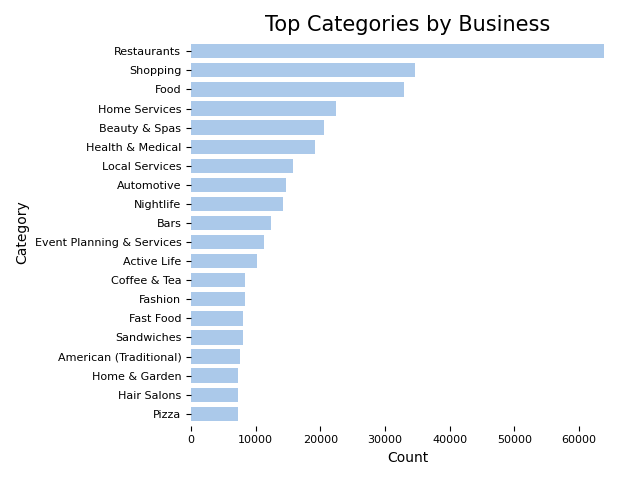

In [13]:
ax = top_20_categories.plot.barh(y='count', x='category', color='#abc9ea', legend=None,width=.75, align='center')
# plt.subplots(figsize=(5, 3))
plt.title('Top Categories by Business', fontsize=15)
plt.xlabel('Count', fontname="Ariel", fontsize=10)
plt.ylabel('Category', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.box(on=None)
plt.tight_layout()
ax.grid(False)
plt.show()
%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely dissatisfied or extremely satisfied with the service received.

How true is this really? Let's try and answer this question.


## Loading Review Data
Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [14]:
review_df = spark.read.json('s3://myyelpbucket/yelp_review.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's begin by listing the business_id and stars columns together for the user reviews data.

In [15]:
review_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the business_id and stars columns together for the user reviews data.

In [18]:
review_df.select('business_id', 'stars').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the stars column to get a resultant dataframe that displays __average stars__ per business as accumulated by users who __took the time to submit a written review.__

In [19]:
review_df.where('text != ""').groupBy('business_id').mean().select('business_id','avg(stars)').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|ATeOjZzE3VOI-RW7F...| 3.433734939759036|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|vbUABNAQI2iwN7v0x...|2.4545454545454546|
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|r-W1HPIZ3V6S2DaXh...| 4.852459016393443|
+--------------------+------------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by business_id.

In [20]:
review_df = review_df.where('text != ""').groupBy('business_id').mean().select('business_id','avg(stars)')
business_reviews = business_df.join(review_df, "business_id")
cols = ['avg(stars)', 'stars', 'name', 'city', 'state']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
business_reviews.select(cols).orderBy('avg(stars)', ascending=False).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+--------------------+---------+-----+
|avg(stars)|stars|                name|     city|state|
+----------+-----+--------------------+---------+-----+
|       5.0|  5.0|         Print Smart| Chandler|   AZ|
|       5.0|  5.0|Martial Arts Cent...|Las Vegas|   NV|
|       5.0|  5.0|     Herbology Tours|Las Vegas|   NV|
|       5.0|  5.0|             Rococoa|  Toronto|   ON|
|       5.0|  5.0|Just Teazzin Hair...|     Mesa|   AZ|
+----------+-----+--------------------+---------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the skew (for lack of a better word) between the avg stars accumulated from written reviews and the actual star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

(row['avg(stars)'] - row['stars']) / row['stars']

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [22]:
business_reviews = business_reviews.withColumn("Skew", (business_reviews['avg(stars)'] - business_reviews['stars']) / business_reviews['stars']).select('Skew')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

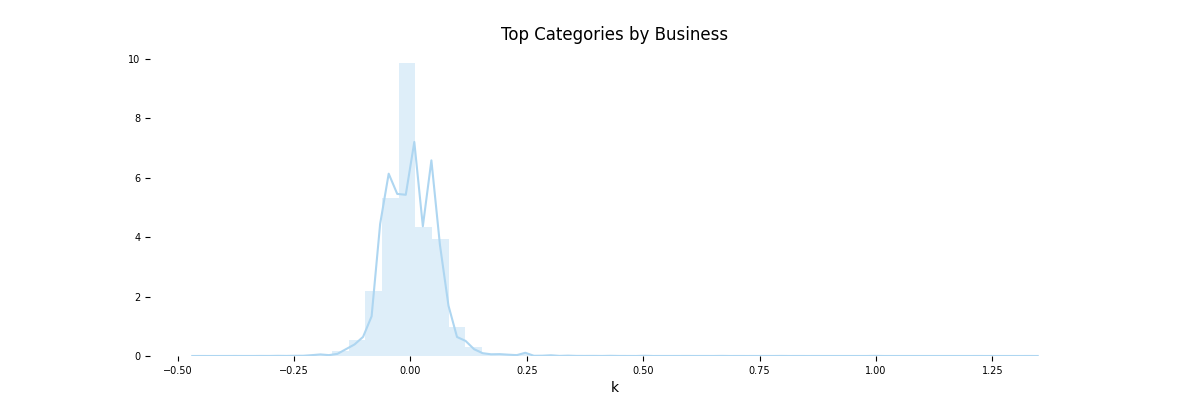

In [23]:
skew_df = business_reviews.select('Skew')
df2 = skew_df.toPandas()
plt.figure(figsize = (12, 4))
sb.distplot(df2['Skew'], color='#AED6F1').tick_params(labelsize=7)
sb.despine(bottom = True, left = True)
plt.title("Top Categories by Business")
plt.xlabel("k")
%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph.

**Answer**: 

Generally speaking, online reviews are a double-edged sword. On one hand, reviews may provide an advantage if they allow consumers to make informed decisions. On the other hand, the vast majority of reviews are often overshadowed by extreme experiences. Unfortunately, components such as selection bias and vote stuffing further sharpen both sides of this double-edged sword. Nowadays, research indicates that the distribution of opinion for review platforms is highly polarized with numerous extreme reviews, and occasional sufficient experiences. Upon seeking a solution, review platforms discovered that, overall, social and monetary incentives decrease bias most. Nonetheless, bias still remains.  

##### Therefore, although the above chart is positively skewed (skew = 1.33) it simply implies that users who took to time to publish reviews weren't as satisfied. In my personal opinion, overall, I think reviews may help but are contingent on several factors depicted in the paragraph above. Personally, when shopping online I like to conduct my own research when purchasing material (place of origin, company, material type, warranty etc.).

# Additional:

#### 1. How does the distribution of ratings for the review data set, when filtered by reviews that contain text, compare to that of the user dataset, irrespective of reviews?

In [24]:
# REVIEW DATASET
review_df = spark.read.json('s3://myyelpbucket/yelp_review.json')
review_df = review_df.where('text != ""').groupBy('business_id').mean().select('business_id','avg(stars)')
review1 = review_df.select('avg(stars)')
review1 = review1.select('avg(stars)').groupBy('avg(stars)').count().orderBy("count", ascending=False)
review1 = review1.withColumnRenamed("avg(stars)", "Average_Stars")
review1 = review1.toPandas()
review1['Average_Stars'] = review1['Average_Stars'].apply(lambda x : "{:.1f}".format(x))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

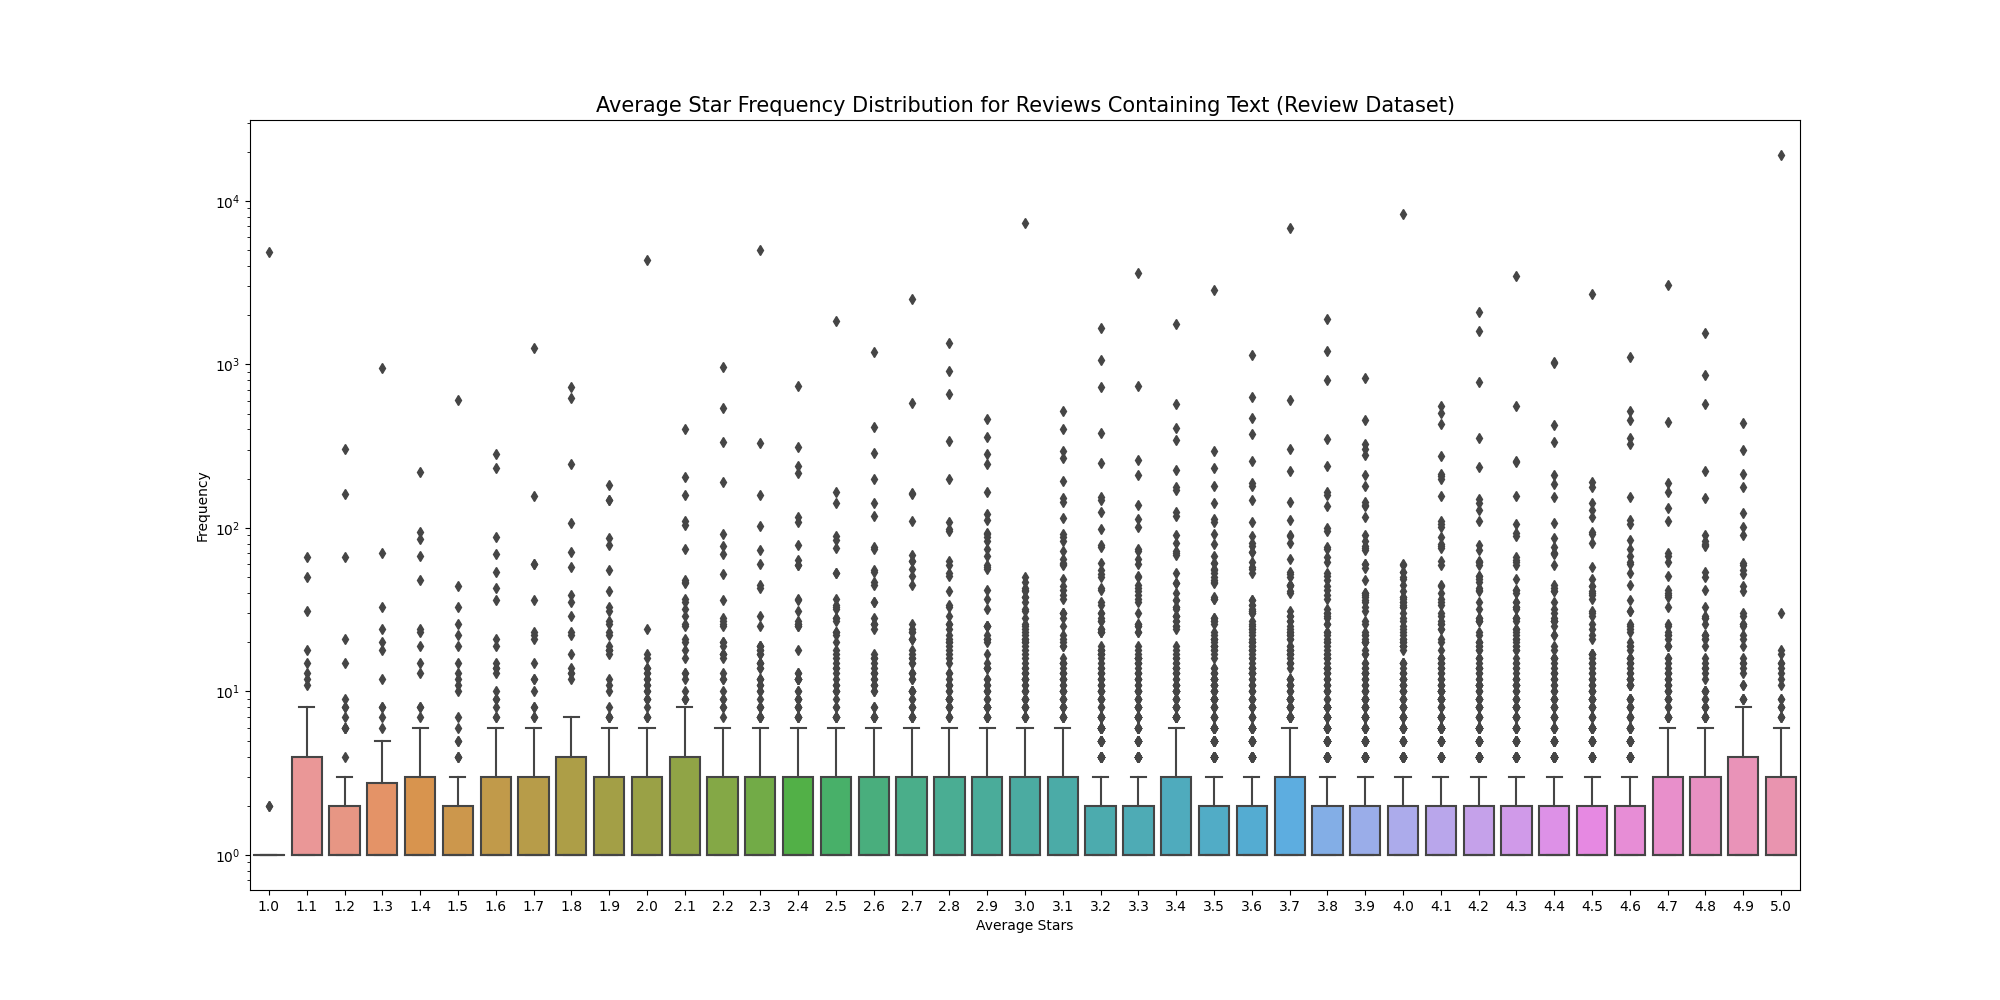

In [25]:
# REVIEW DATASET
plt.subplots(figsize=(20, 10))
# sb.distplot(df3['average_stars'], color='#AED6F1').tick_params(labelsize=7)
a = sb.boxplot(data = review1, x = 'Average_Stars', y='count')
%matplot plt
a.set(yscale = "log")
plt.title("Average Star Frequency Distribution for Reviews Containing Text (Review Dataset)", fontsize=15)
plt.xlabel("Average Stars")
plt.ylabel("Frequency")
%matplot plt

#### Interestingly, we can observe that when the reviews dataset is filtered to only contain reviews with text, the population frequencies appear to be fairly scattered with the exception of a few outliers. Generally speaking, cluster applications would seem to strongly applicable here becasue, overall, ratings within particular neighborhoods, appear to have approximately similar counts.

In [26]:
# USERS DATASET
user_df = spark.read.json('s3://myyelpbucket/yelp_user.json')
df = user_df.select('average_stars')
df2 = df.select('average_stars').groupBy('average_stars').count().orderBy("count", ascending=False)
df3 = df2.toPandas()
df3['average_stars'] = df3['average_stars'].apply(lambda x : "{:.1f}".format(x))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

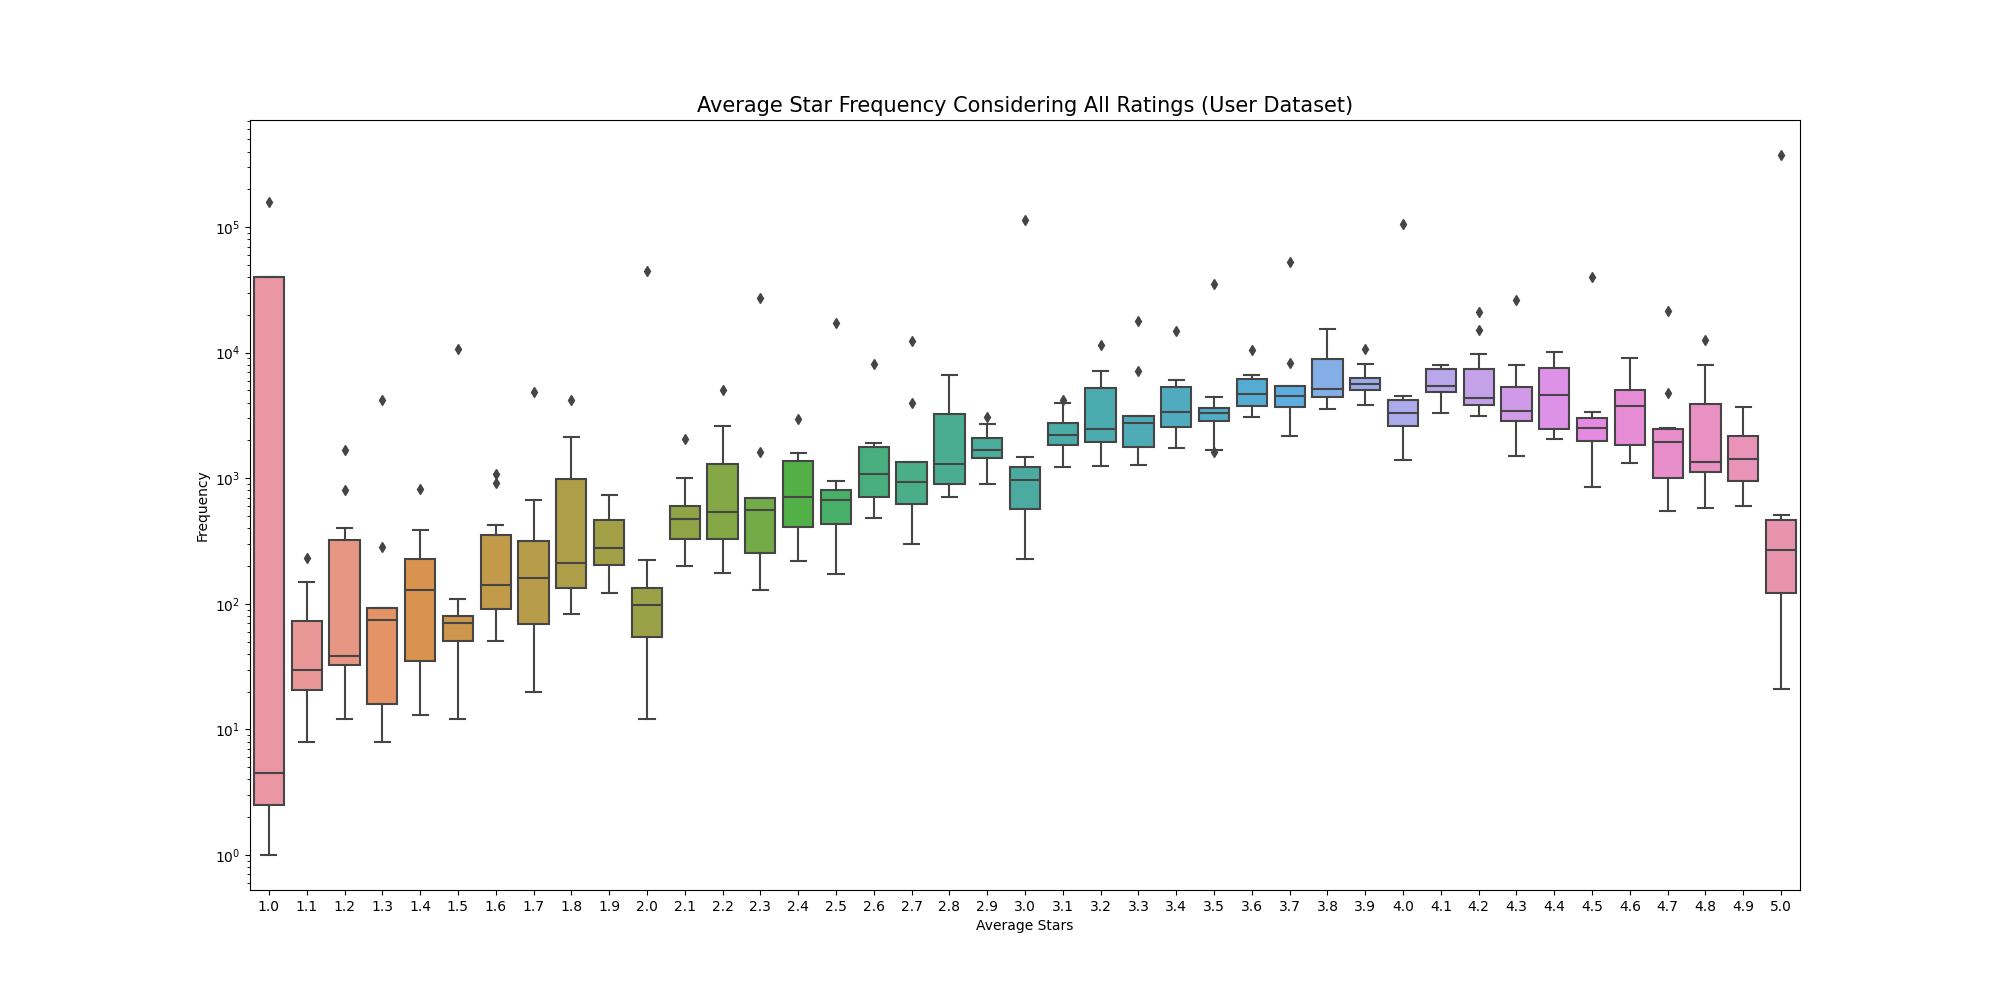

In [27]:
# USERS DATASET
plt.subplots(nrows=1, figsize=(20, 10))
b = sb.boxplot(data = df3, x = 'average_stars', y='count')
b.set(yscale = "log")
plt.title("Average Star Frequency Considering All Ratings (User Dataset)", fontsize=15)
plt.xlabel("Average Stars")
plt.ylabel("Frequency")
%matplot plt

### On the other hand, when we filter the users dataset for all ratings, irrespective of reviews, we see that oscillation is clearly more evident. This raises an array of interesting questions. For example, could the astonishing volume of low ratings be due to users who were so dissatisfied, that they couldn't even bother to submit a review? In short, this dataset allows one to investigate a multitude of questions. Therefore, robust statistical analysis and NLP methods will be applied in Summer of 2020 to gain granular detail.

#### 2. In the business dataset, on average, which state has the lowest rated reviews?

In [28]:
business_df = spark.read.json('s3://myyelpbucket/yelp_business.json')
df1 = business_df.groupby('state').mean().select('state','avg(stars)').orderBy('avg(stars)', ascending=True)
df1.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+------------------+
|state|        avg(stars)|
+-----+------------------+
|   VA|               1.5|
|   BC|               1.5|
|   HI|               2.0|
|   CO|              2.25|
|   OR|               2.5|
|   YT|               2.5|
|   MO|               2.5|
|  DUR|               2.5|
|   AK|               2.5|
|   FL|2.6666666666666665|
|   NE|              2.75|
|   WA|               2.8|
|   GA|2.8333333333333335|
|  DOW|               3.0|
|   TX|3.0833333333333335|
|   UT|              3.25|
|   NY|              3.25|
|   ON|3.3228219619406447|
|   AB|3.3242340474545036|
|   IL|3.3918387413962634|
+-----+------------------+
only showing top 20 rows

As we depicted in the output above, with respect to the business dataset, on average, online reviews for Virginia and British Columbia are tied to have the lowest rating of all states.

# Part 4: Exploratory data analysis using all 3 datasets

#### Using the user and review dataset:
1. Does the distribution of the yearly grand average appear stable?
2. How are the average number of reviews distributed over the years by users?

#### Above in conjunction with the business dataset:
3. Overall, do the "elite" and "non-elite" tend to visit similar businesses?
4. On average, who gives higher ratings between "elite" and "non-elite" users?

In [29]:
# Upload user and review datasets 
user_df = spark.read.json('s3://myyelpbucket/yelp_user.json')
review_df = spark.read.json('s3://myyelpbucket/yelp_review.json')

# Merge the two datasets on "user_id":
user_reviews = user_df.join(review_df, "user_id")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### 1. Does the distribution of the yearly grand average remain stable over the years?

In [30]:
# Extract the "year" from date and create a new column containing Year: 
user_reviews2 = user_reviews.withColumn("Year",year(user_reviews['date']))

# Using the new "Year" column we obtain grand averages by year:
avg_stars_years = user_reviews2.select("Year", 'average_stars')
avg_stars_years = avg_stars_years.groupBy("Year").mean().select(["Year", "avg(average_stars)"]).orderBy('Year', ascending=False)
avg_stars_years = avg_stars_years.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

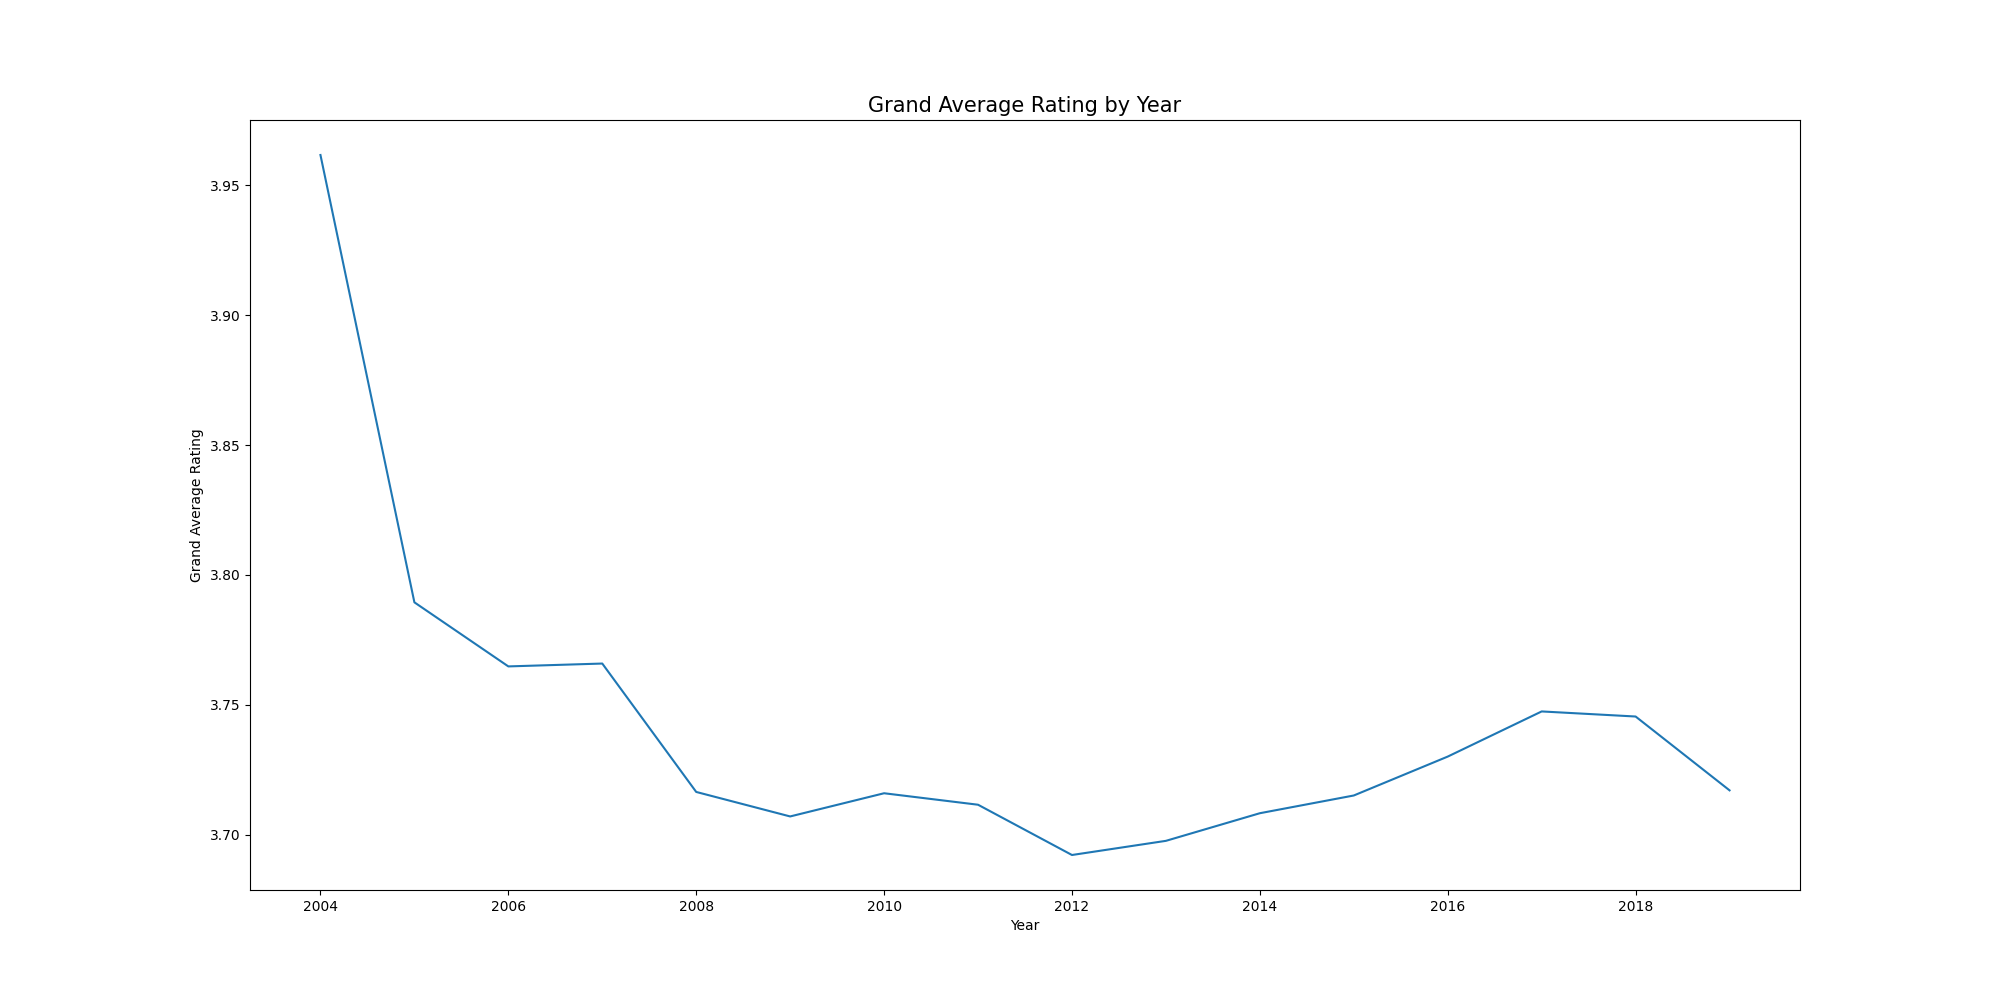

In [31]:
plt.subplots(nrows=1, figsize=(20, 10))
ax = sb.lineplot(x="Year", y="avg(average_stars)", data=avg_stars_years)
plt.title("Grand Average Rating by Year", fontsize=15)
plt.xlabel("Year")
plt.ylabel("Grand Average Rating")
%matplot plt

In the plot above, we see that though there is a steep decline from 2004 to 2005, overall, the grand average ratings remain fairly stable between the bounds of 3.70 and approximately 3.95. Interestingly, ___none___ of the years seem to have extreme ratings (≤2 or 4≤) for grand averages, implying that the overall reviews are satisfactory. 

#### 2. How are the average number of reviews distributed over the years by users?

In [32]:
# user_reviews = user_df.join(review_df, "user_id")
user_reviews3 = user_reviews.withColumn("Year",year(user_reviews['date']))
avg_review = user_reviews3.select("Year", 'average_stars','review_count' )
avg_review = avg_review.groupBy("Year").mean().select(["Year", 'avg(review_count)']).orderBy('Year', ascending=False)
avg_review = avg_review.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

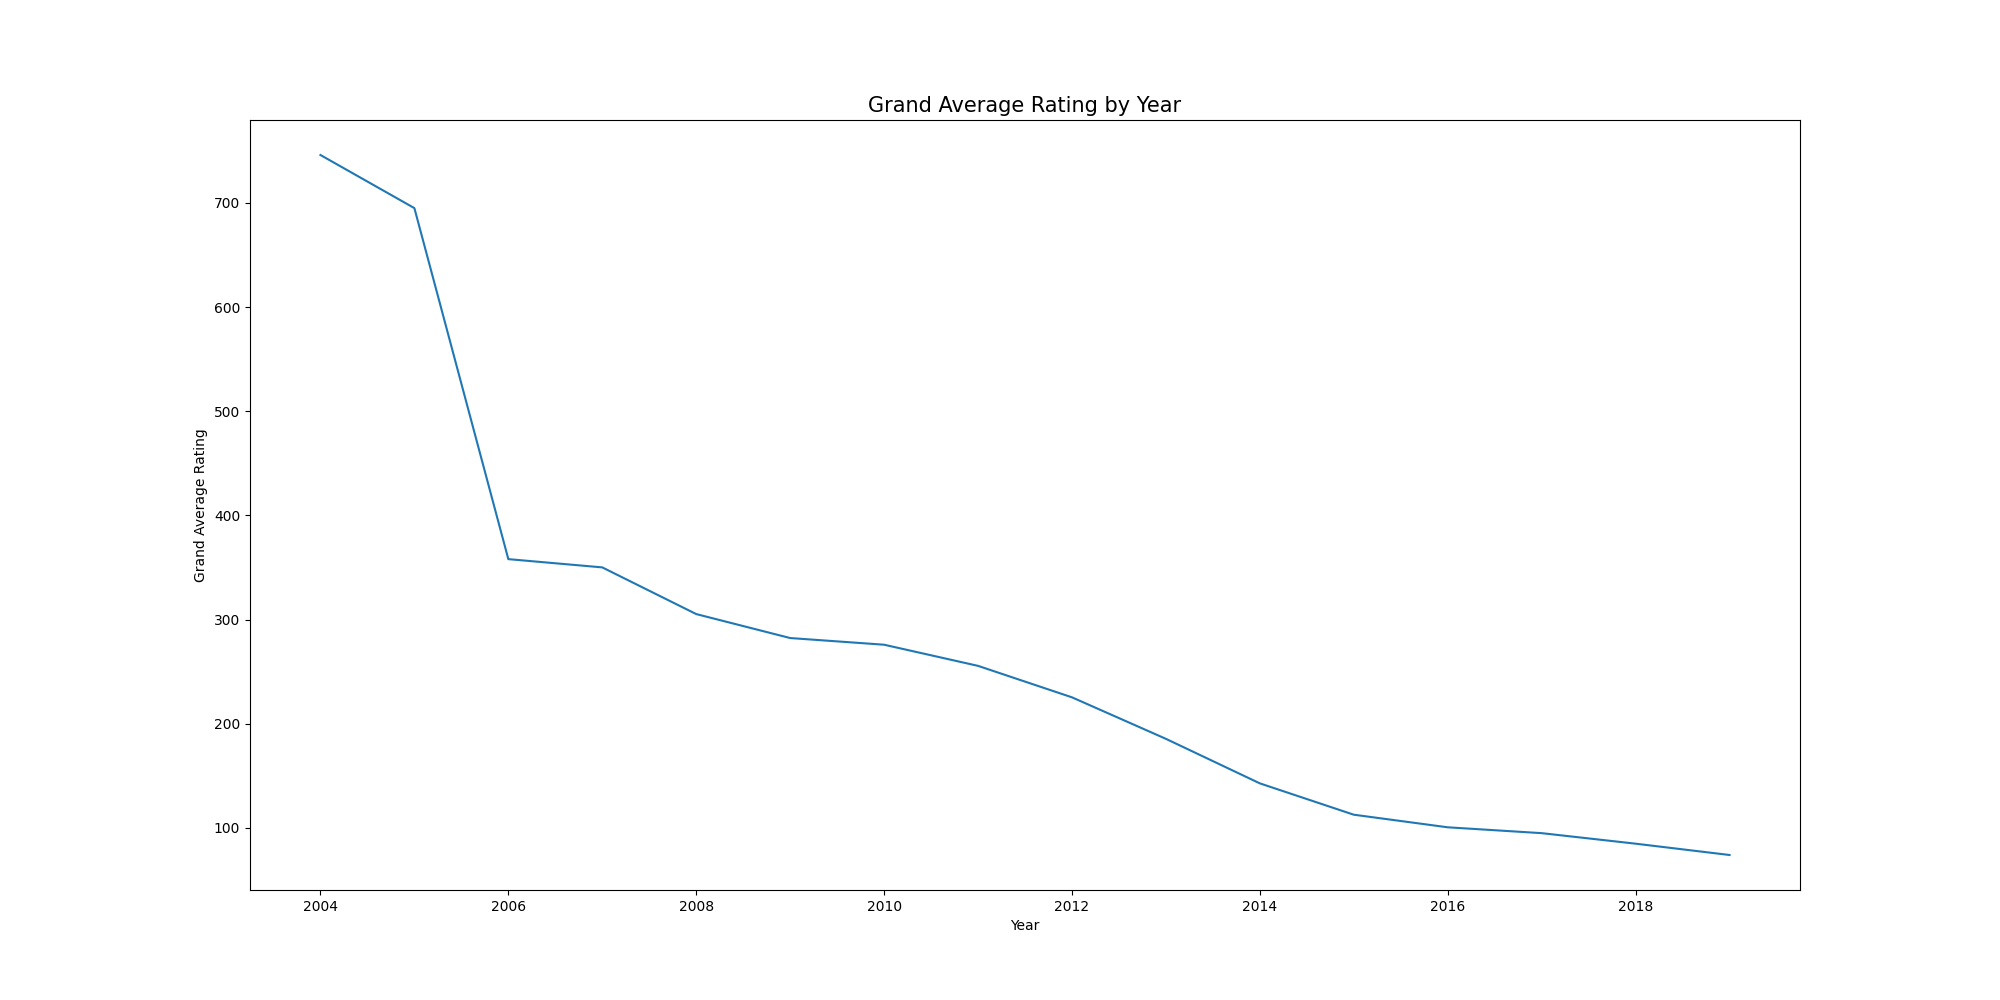

In [35]:
ax = sb.lineplot(x="Year", y="avg(review_count)", data=avg_review)
plt.title("Grand Average Rating by Year", fontsize=15)
plt.xlabel("Year")
plt.ylabel("Grand Average Rating")
%matplot plt

Over the years, the average number of reviews has clearly experienced an elbow-like decline. Interestingly, a sharp decline exists for relatively similar years in the Grand Average plot. 

#### 3. Overall, do the "elite" and "non-elite" tend to visit similar businesses?

In [36]:
user_df = spark.read.json('s3://myyelpbucket/yelp_user.json')
business_df = spark.read.json('s3://myyelpbucket/yelp_business.json')
review_df = spark.read.json('s3://myyelpbucket/yelp_review.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
# Trim columns
review_df2 = review_df.select('business_id', 'user_id')

user_df = user_df.select('user_id', 'review_count', 'useful',
                         'funny', 'cool', 'elite',  'fans', 'average_stars',
                         'compliment_hot','compliment_more',
                         'compliment_profile','compliment_cute',
                         'compliment_list','compliment_note',
                         'compliment_plain','compliment_cool',
                         'compliment_funny','compliment_writer',
                         'compliment_photos')

# Merge user_df and review_df2 on "user_id":
user_reviews = user_df.join(review_df2, "user_id")
# All datasets merged:
user_reviews2 = user_reviews.join(business_df, "business_id")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
# Filter for elite amd non-elite users:
elite = user_reviews2.where('elite != ""').select('business_id', 'average_stars','name', 'user_id')
non_elite = user_reviews2.where('elite == ""').select('business_id', 'average_stars','name','user_id')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
elite.groupBy('business_id').count().orderBy("count", ascending=False).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|count|
+--------------------+-----+
|RESDUcs7fIiihp38-...| 2985|
|4JNXUYY8wbaaDmk3B...| 2739|
|K7lWdNUhCbcnEvI0N...| 2711|
|DkYS3arLOhA8si5uU...| 2492|
|FaHADZARwnY4yvlvp...| 2481|
|iCQpiavjjPzJ5_3gP...| 2062|
|2weQS-RnoOBhb1KsH...| 1826|
|f4x1YBxkLrZg652xt...| 1821|
|rcaPajgKOJC2vo_l3...| 1690|
|5LNZ67Yw9RD6nf4_U...| 1657|
|ujHiaprwCQ5ewziu0...| 1657|
|JmI9nslLD7KZqRr__...| 1531|
|Wxxvi3LZbHNIDwJ-Z...| 1504|
|eoHdUeQDNgQ6WYEnP...| 1495|
|cYwJA2A6I12KNkm2r...| 1473|
|SMPbvZLSMMb7KU76Y...| 1455|
|MpmFFw0GE_2iRFPds...| 1436|
|El4FC8jcawUVgw_0E...| 1382|
|P7pxQFqr7yBKMMI2J...| 1356|
|QJatAcxYgK1Zp9BRZ...| 1280|
+--------------------+-----+
only showing top 20 rows

In [42]:
non_elite.groupBy('business_id').count().orderBy("count", ascending=False).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|count|
+--------------------+-----+
|RESDUcs7fIiihp38-...| 7432|
|4JNXUYY8wbaaDmk3B...| 6797|
|f4x1YBxkLrZg652xt...| 5038|
|K7lWdNUhCbcnEvI0N...| 4883|
|cYwJA2A6I12KNkm2r...| 4113|
|vHz2RLtfUMVRPFmd7...| 4073|
|QXV3L_QFGj8r6nWX2...| 3840|
|JDZ6_yycNQFTpUZzL...| 3837|
|faPVqws-x-5k2CQKD...| 3820|
|AV6weBrZFFBfRGCbc...| 3661|
|3kdSl5mo9dWC4clrQ...| 3510|
|OETh78qcgDltvHULo...| 3408|
|YJ8ljUhLsz6CtT_2O...| 3345|
|5LNZ67Yw9RD6nf4_U...| 3316|
|SMPbvZLSMMb7KU76Y...| 3294|
|HhVmDybpU7L50Kb5A...| 3239|
|El4FC8jcawUVgw_0E...| 3207|
|hihud--QRriCYZw1z...| 3139|
|u_vPjx925UPEG9DFO...| 3132|
|2weQS-RnoOBhb1KsH...| 3127|
+--------------------+-----+
only showing top 20 rows

#### The two outputs above indicate that both non-elite users and elite users shared reviews for the same top 2 business_id's. Distinctively, results change when filtered by name, below. However, an evident overlap of business names by elite and non-elite users remains.

In [43]:
elite.groupBy('name').count().orderBy("count", ascending=False).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|                name|count|
+--------------------+-----+
|           Starbucks| 9248|
|  Hash House A Go Go| 3356|
|          McDonald's| 3227|
|    Bacchanal Buffet| 2985|
|     In-N-Out Burger| 2901|
|    Earl of Sandwich| 2741|
|        Mon Ami Gabi| 2739|
|        Wicked Spoon| 2711|
|Chipotle Mexican ...| 2551|
|McCarran Internat...| 2481|
|         Shake Shack| 2125|
|        Secret Pizza| 2062|
|        Panera Bread| 2022|
|The Cheesecake Fa...| 1845|
|  The Buffet At Wynn| 1826|
|      Grand Lux Cafe| 1796|
|              Target| 1791|
|  Buffalo Wild Wings| 1726|
|          Yard House| 1696|
|             Bouchon| 1690|
+--------------------+-----+
only showing top 20 rows

In [44]:
non_elite.groupBy('name').count().orderBy("count", ascending=False).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|                name|count|
+--------------------+-----+
|           Starbucks|20838|
|          McDonald's|17179|
|  Hash House A Go Go| 9978|
|Chipotle Mexican ...| 8882|
|    Bacchanal Buffet| 7432|
|  Buffalo Wild Wings| 7426|
|             Denny's| 6890|
|        Mon Ami Gabi| 6797|
|             Dunkin'| 6369|
|        Panera Bread| 6311|
|       Discount Tire| 6159|
|Oregano's Pizza B...| 5931|
|           Taco Bell| 5852|
|           Egg Works| 5771|
|The Cheesecake Fa...| 5725|
|                IHOP| 5662|
|  Subway Restaurants| 5466|
|  Outback Steakhouse| 5412|
|         Chick-fil-A| 5328|
|     In-N-Out Burger| 5321|
+--------------------+-----+
only showing top 20 rows

#### If there are multiple unique user_ids under both "elite" and "non-elite" we can average their ratings to obtain a grand average for business_id's to observe key differences in the distribution.

In [45]:
# Check for elite counts
elite.groupBy('user_id').count().orderBy("count", ascending=False).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|             user_id|count|
+--------------------+-----+
|CxDOIDnH8gp9KXzpB...| 4331|
|bLbSNkLggFnqwNNzz...| 2555|
|PKEzKWv_FktMm2mGP...| 1972|
|DK57YibC5ShBmqQl9...| 1817|
|U4INQZOPSUaj8hMjL...| 1762|
|hWDybu_KvYLSdEFzG...| 1602|
|QJI9OSEn6ujRCtrX0...| 1499|
|d_TBs6J3twMy9GChq...| 1424|
|YRcaNlwQ6XXPFDXWt...| 1263|
|dIIKEfOgo0KqUfGQv...| 1260|
|cMEtAiW60I5wE_vLf...| 1245|
|UYcmGbelzRa0Q6Jqz...| 1214|
|PcvbBOCOcs6_suRDH...| 1157|
|n86B7IkbU20AkxlFX...| 1152|
|U5YQX_vMl_xQy8EQD...| 1148|
|3nDUQBjKyVor5wV0r...| 1126|
|Q9mA60HnY87C1TW5k...| 1123|
|ic-tyi1jElL_umxZV...| 1111|
|iDlkZO2iILS8Jwfdy...| 1106|
|Ry1O_KXZHGRI8g5zB...| 1101|
+--------------------+-----+
only showing top 20 rows

In [46]:
# Check for non-elite counts
non_elite.groupBy('user_id').count().orderBy("count", ascending=False).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|             user_id|count|
+--------------------+-----+
|ELcQDlf69kb-ihJfx...| 2039|
|rCWrxuRC8_pfagpch...| 1159|
|V-BbqKqO8anwplGRx...|  979|
|L8P5OWO1Jh4B2HLa1...|  900|
|dt9IHwfuZs9D9LOH7...|  894|
|Q4Qfu-3vYtL1LRm2X...|  702|
|keBv05MsMFBd0Hu98...|  658|
|EsOu51dW3UTDJTApB...|  629|
|tWBLn4k1M7PLBtAtw...|  607|
|DPitNu466172os6m0...|  580|
|UtkjXTiMfGRz4R1zD...|  579|
|3xBFFH866WoySDG7u...|  566|
|v7FPnMzdbl6J7U_8H...|  563|
|9hMqNBBpTl3lBy6qC...|  525|
|lyfYBqtDGJJ1c98pf...|  509|
|Q7IoE5m2heQKThuVq...|  496|
|4d13xAX2jp2EbGF8I...|  496|
|0ygWZ_gXF8qTm0bY9...|  478|
|LfKyD_XaTnfKoKujR...|  477|
|WP7FsUsgNW24s7HH5...|  471|
+--------------------+-----+
only showing top 20 rows

In [57]:
eliteratings = elite.groupBy('business_id').mean().orderBy("avg(average_stars)", ascending=False)
noneliteratings = non_elite.groupBy('business_id').mean().orderBy("avg(average_stars)", ascending=False)
eliteratings = eliteratings.toPandas()
noneliteratings = noneliteratings.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

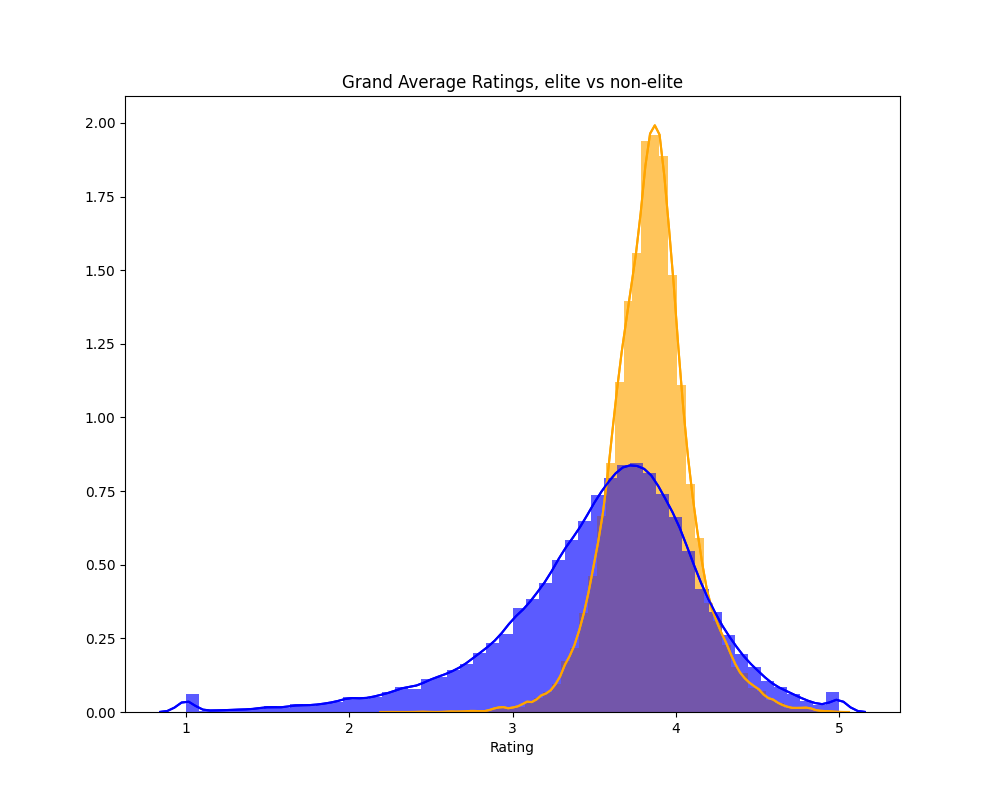

In [58]:
sb.distplot(eliteratings['avg(average_stars)'], color='orange', label="non-elite")
sb.distplot(noneliteratings['avg(average_stars)'], color='blue', label="elite")
plt.title("Grand Average Ratings, elite vs non-elite")
plt.xlabel("Rating")
%matplot plt

#### From the above, we may conclude that, overall, non-elite reviews are more distriibuted. "Elite" users tend to have narrower rating paterns, indicated by the orange distribution. "Non-Elite" reviewers also apeear to be more extreme in there rating habits.